# Clustering selon les tables

In [540]:
import os
import pandas as pd
from tqdm import tqdm

def build_texts_from_tsv(tsv_path, base_dir="WikiTableQuestions/WikiTableQuestions/csv"):
    df = pd.read_csv(tsv_path, sep='\t')
    texts = []
    ids = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Construction des textes"):
        question = str(row["utterance"])
        context_path = row["context"].strip()

        if context_path.startswith("csv/"):
            context_path = context_path[len("csv/"):]
        full_path = os.path.normpath(os.path.join(base_dir, context_path))
        
        try:
            table_df = pd.read_csv(
                full_path, 
                dtype=str, 
                engine="python", on_bad_lines="skip"
            ).fillna("")
            
            table_text = " ".join(table_df.values.flatten())
            full_text = f"{question} {table_text}"
            
            texts.append(full_text)
            ids.append(row["id"])
        
        except Exception as e:
            print(f"Erreur lors du chargement de {full_path}: {e}")
            continue
    
    print(f"{len(texts)} exemples valides construits.")
    return texts, ids

texts, ids = build_texts_from_tsv("WikiTableQuestions/WikiTableQuestions/data/training.tsv")

Construction des textes: 100%|██████████| 14149/14149 [00:38<00:00, 368.12it/s]


14149 exemples valides construits.


In [545]:
import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stops = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+(\.\d+)?\b', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stops]
    text = re.sub(r'\s+', ' ', ' '.join(tokens)).strip()
    text = text.replace('nan', '')
    return text

model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yacin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [549]:
""" cleaned_docs = [clean_text(doc) for doc in texts]
import pickle
# save cleaned docs and ids
with open("cleaned_docs.pkl", "wb") as f:
	pickle.dump(cleaned_docs, f)	

with open("ids.pkl", "wb") as f:
    pickle.dump(ids, f) """

' cleaned_docs = [clean_text(doc) for doc in texts]\nimport pickle\n# save cleaned docs and ids\nwith open("cleaned_docs.pkl", "wb") as f:\n\tpickle.dump(cleaned_docs, f)\t\n\nwith open("ids.pkl", "wb") as f:\n    pickle.dump(ids, f) '

In [550]:
import pickle
import numpy as np

with open("cleaned_docs.pkl", "rb") as f:
    cleaned_docs = pickle.load(f)

with open("ids.pkl", "rb") as f:
	ids = pickle.load(f)
 
print(f"Number of cleaned documents: {len(cleaned_docs)}")
print(f"Number of IDs: {len(ids)}")

# embeddings = model.encode(cleaned_docs, batch_size=64, show_progress_bar=True)
embeddings = np.load("table_embeddings.npy")
print(f"Embeddings shape: {embeddings.shape}")

Number of cleaned documents: 14149
Number of IDs: 14149
Embeddings shape: (14149, 384)


In [551]:
import umap
import matplotlib.pyplot as plt
import numpy as np
reducer = umap.UMAP(n_neighbors=100, n_components=2, random_state=42, metric='cosine')
X_reduced = reducer.fit_transform(embeddings)


c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Nombre de clusters détectés : 12


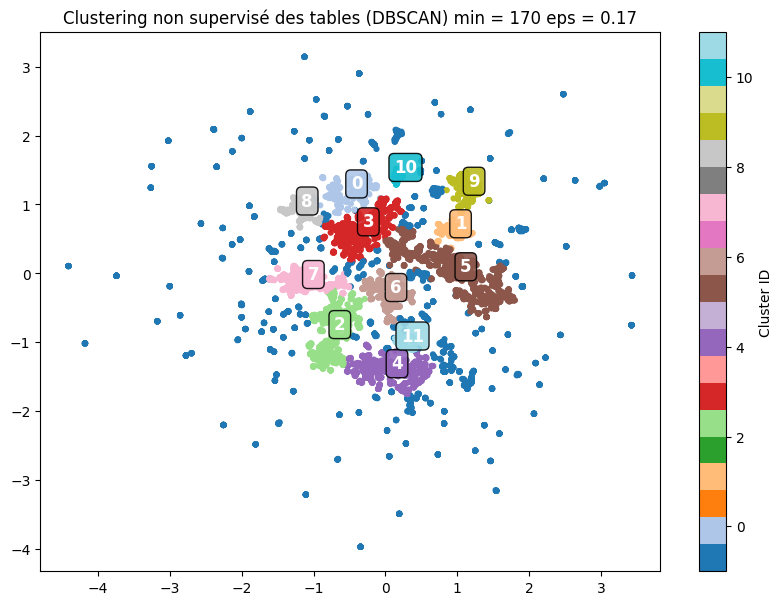

In [557]:
from sklearn.cluster import DBSCAN

EPS = 0.17
min_samples = 170
X_reduced_n = (X_reduced - X_reduced.mean(axis=0)) / (X_reduced.std(axis=0)+1e-20)
dbscan = DBSCAN(eps=EPS, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(X_reduced_n)

nb_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Nombre de clusters détectés : {nb_clusters}")

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced_n[:, 0], X_reduced_n[:, 1], c=labels, s=nb_clusters, cmap='tab20')
for cluster_id in set(labels):
	if cluster_id == -1:
		continue
	cluster_points = X_reduced_n[labels == cluster_id]
	if len(cluster_points) == 0:
		continue
	center = cluster_points.mean(axis=0)
	plt.text(center[0]+0.1, center[1]+0.1, str(cluster_id), fontsize=12, weight='bold', 
			horizontalalignment='center', verticalalignment='center', color='white',
			bbox=dict(facecolor=scatter.cmap(scatter.norm(cluster_id)), alpha=0.9, boxstyle='round,pad=0.3'))
	
plt.title("Clustering non supervisé des tables (DBSCAN) min = "+ str(min_samples) +" eps = " + str(EPS))
plt.colorbar(scatter, label="Cluster ID")
plt.show()


Cluster 0 : 775 documents


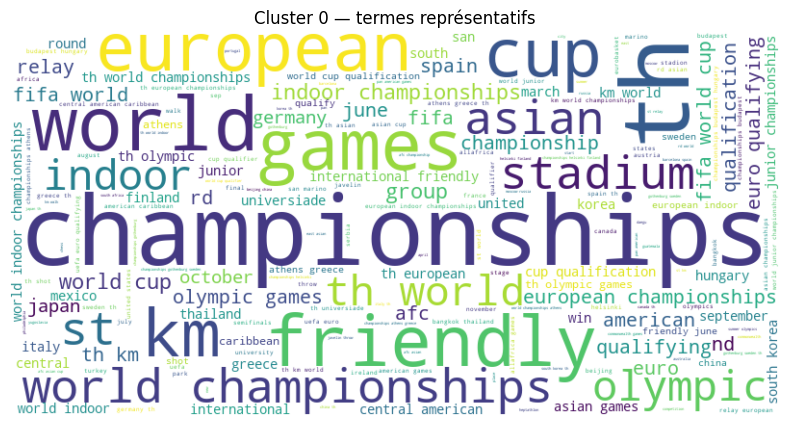

Cluster 1 : 384 documents


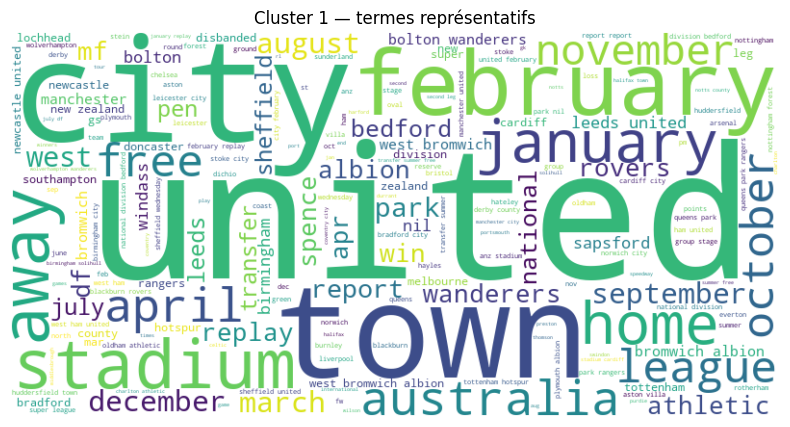

Cluster 2 : 1400 documents


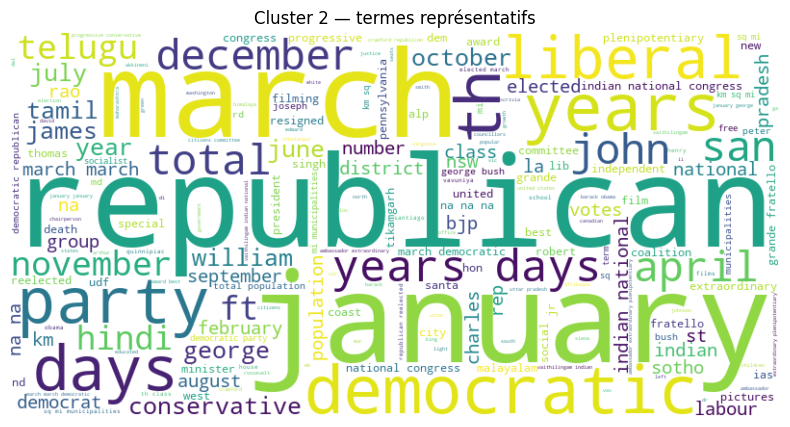

Cluster 3 : 1482 documents


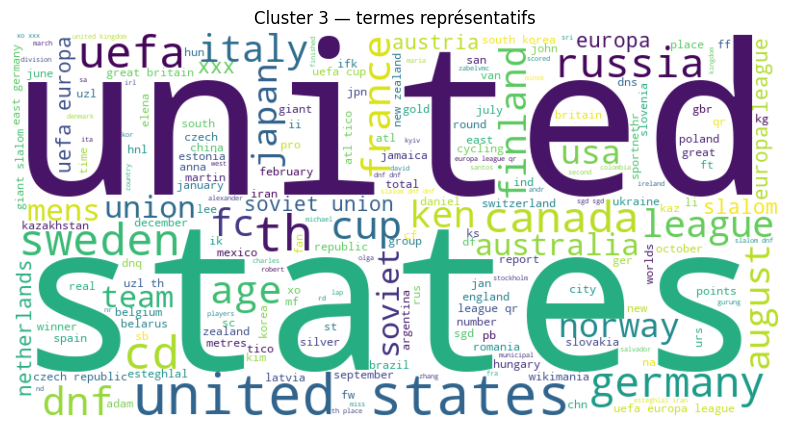

Cluster 4 : 1158 documents


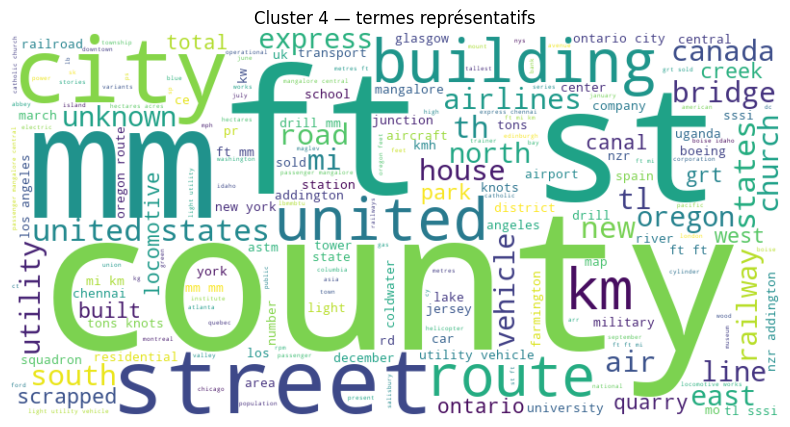

Cluster 5 : 2362 documents


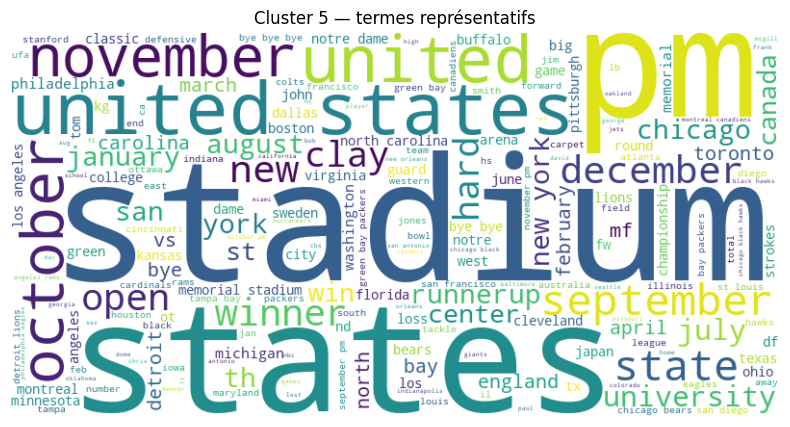

Cluster 6 : 814 documents


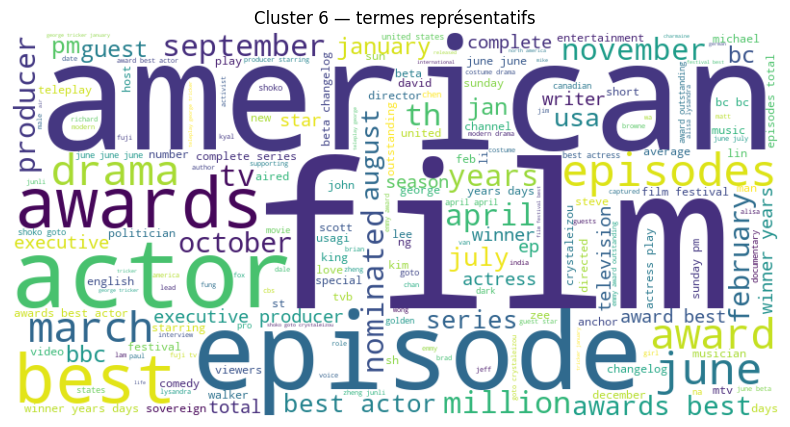

Cluster 7 : 1077 documents


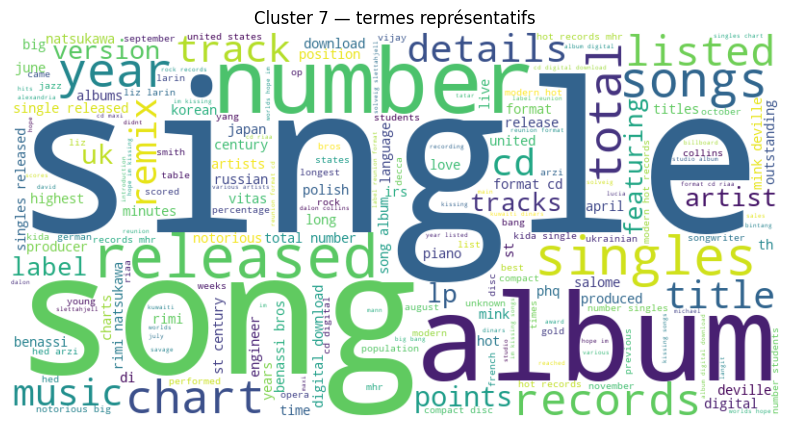

Cluster 8 : 632 documents


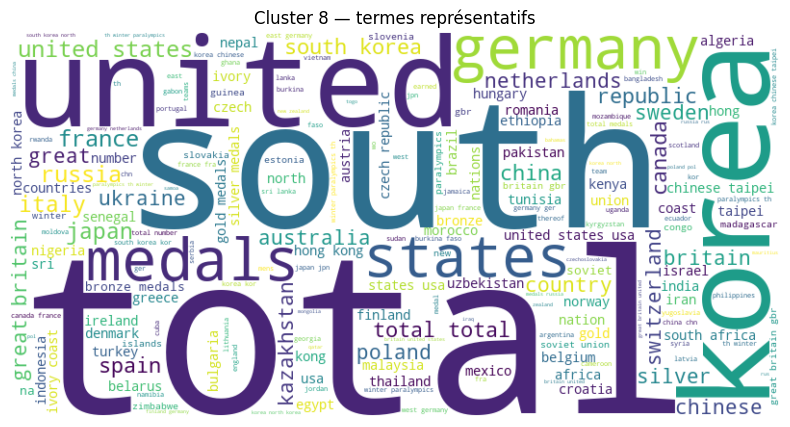

Cluster 9 : 625 documents


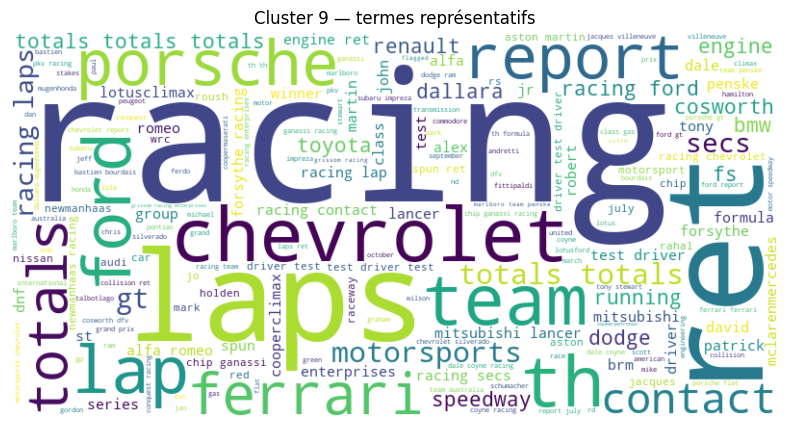

Cluster 10 : 184 documents


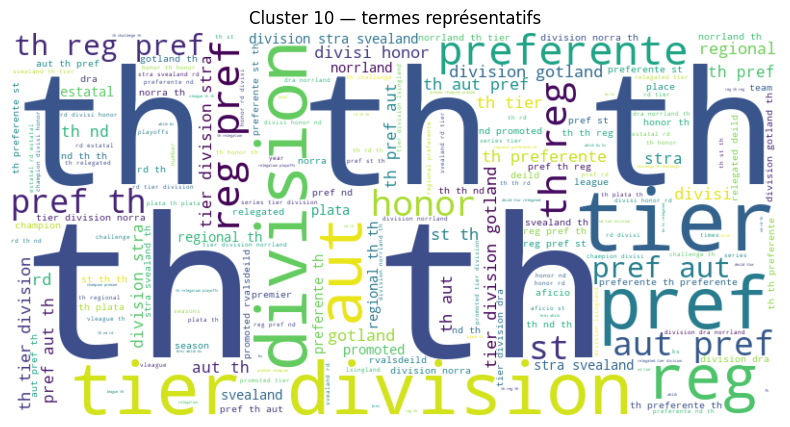

Cluster 11 : 170 documents


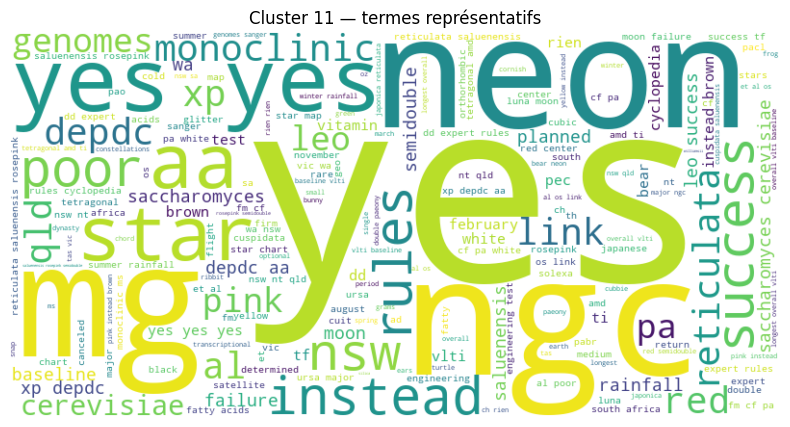

In [559]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

for cluster_id in range(dbscan.labels_.max() + 1):
	cluster_texts = [cleaned_docs[i] for i in range(len(cleaned_docs)) if dbscan.labels_[i] == cluster_id]
	if not cluster_texts:
		continue

	try: 
		tfidf = TfidfVectorizer(stop_words = "english", ngram_range=(1,3), max_df=0.8)
		tfidf_matrix = tfidf.fit_transform(cluster_texts)
		scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
		terms = tfidf.get_feature_names_out()

		freq_dict = dict(zip(terms, scores))
		wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
		print(f"Cluster {cluster_id} : {len(cluster_texts)} documents")

		plt.figure(figsize=(10, 5))
		plt.imshow(wordcloud, interpolation='bilinear')
		plt.axis("off")
		plt.title(f"Cluster {cluster_id} — termes représentatifs")
		plt.show()
	except Exception as e:
		print(f"Erreur pour le cluster {cluster_id}: {e}")


In [ ]:
import pandas as pd

initial_clusters = {
    0: "Championships",
    1: "football",
    2: "American politics",
    3: "International leagues (like football)",
    4: "City infrastructure and transportation",
    5: "North American sports",
    6: "Film and TV",
    7: "Music",
    8: "Geography",
    9: "Cars and racing",
    10: "Regionals",
    11: "Science",
    -1: "Noise"
}
df = pd.read_csv("WikiTableQuestions/WikiTableQuestions/data/training.tsv", sep="\t")
cluster_dict = dict(zip(ids, [initial_clusters.get(int(lbl), "Noise") for lbl in labels]))
df["cluster_name"] = df["id"].map(cluster_dict).fillna("Noise")

cluster_groups = {
    "Sports": [
        "football",
        "Championships",
        "International leagues (like football)",
        "North American sports",
        "Cars and racing",
        "Regionals"
    ],
    "Politics": ["American politics"],
    "General knowledge": ["City infrastructure and transportation"],
    "Film": ["Film and TV"],
    "Music": ["Music"],
    "Geography": ["Geography"],
    "Science": ["Science"],
    "Noise": ["Noise"]
}


fusion_map = {name: super_cat for super_cat, names in cluster_groups.items() for name in names}
df["cluster"] = df["cluster_name"].map(fusion_map).fillna("Other")

mask = (df["cluster"] == "Geography") & (df["utterance"].str.contains("medal", case=False, na=False) 
                                         | df["utterance"].str.contains("final", case=False, na=False)
										 | df["utterance"].str.contains("score", case=False, na=False)
										|  df["utterance"].str.contains("rank", case=False, na=False)
                                            )
df.loc[mask, "cluster"] = "Sports"


df.drop(columns=["cluster_name"], inplace=True)
df.to_csv("WikiTableQuestions/WikiTableQuestions/data/training_clusters.tsv", sep="\t", index=False)
print(df["cluster"].value_counts())


✅ Fichier enregistré : training_with_superclusters.tsv
cluster
Sports               6250
Noise                3086
Politics             1400
General knowledge    1158
Music                1077
Film                  814
Geography             194
Science               170
Name: count, dtype: int64


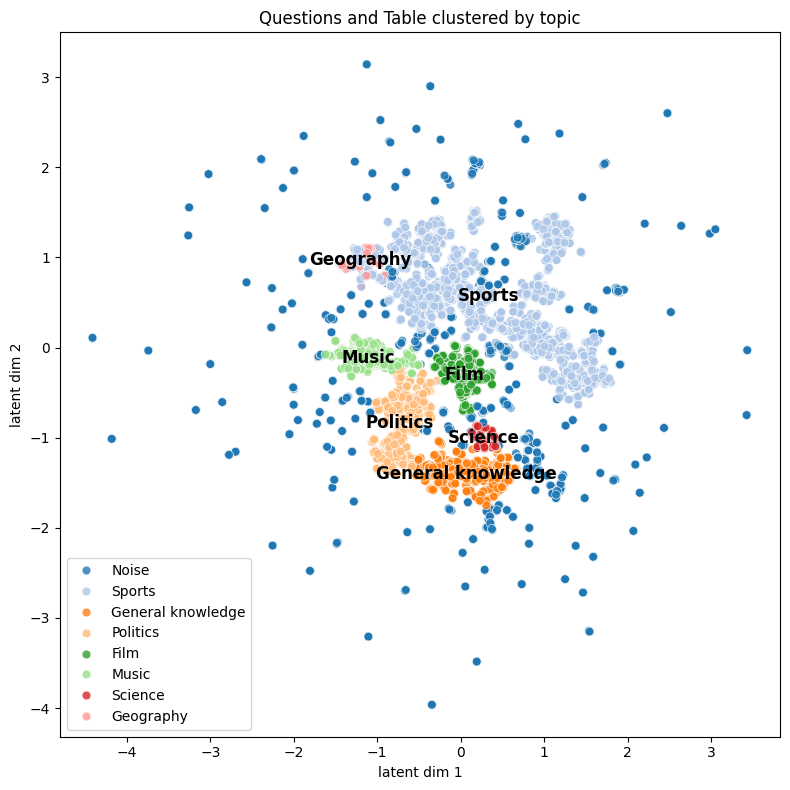

In [604]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

plot_df = pd.DataFrame({
	"x": X_reduced_n[:, 0],
	"y": X_reduced_n[:, 1],
	"cluster": df["cluster"]})

plt.figure(figsize=(8, 8))
sns.scatterplot(
	data=plot_df,
	x="x",
	y="y",
	hue="cluster",
	palette="tab20",
	s=40,
	alpha=0.8,
	legend="full"
)
plt.title("Questions and Table clustered by topic")
plt.xlabel("latent dim 1")
plt.ylabel("latent dim 2")
for cluster_name in plot_df['cluster'].unique():
	if cluster_name == "Noise":
		continue
	cluster_points = plot_df[plot_df['cluster'] == cluster_name]
	x_mean = cluster_points['x'].mean()
	y_mean = cluster_points['y'].mean()
	plt.text(x_mean, y_mean, cluster_name, fontsize=12, weight='bold', 
			horizontalalignment='center', verticalalignment='center')

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
